In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

8783
8783
8783
8783
8783


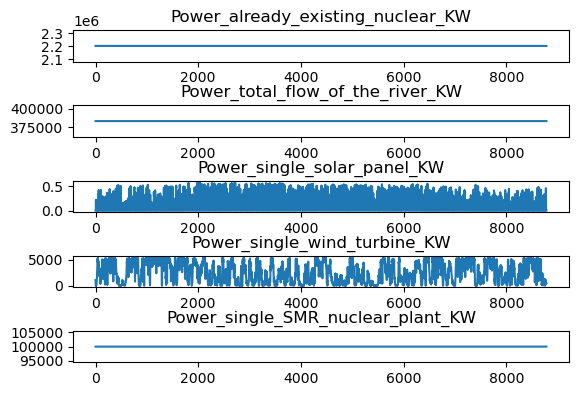

In [2]:
#from excels to numpy arrays

Power_total_demand_KW             = pd.read_excel('Power_total_demand_KW.xlsx').to_numpy()

Power_already_existing_nuclear_KW = pd.read_excel('Power_already_existing_nuclear_KW.xlsx').to_numpy()
Power_total_flow_of_the_river_KW  = pd.read_excel('Power_total_flow_of_the_river_KW.xlsx').to_numpy()

Power_single_solar_panel_KW       = pd.read_excel('Power_single_solar_panel_KW.xlsx').to_numpy()
Power_single_wind_turbine_KW      = pd.read_excel('Power_single_wind_turbine_KW.xlsx').to_numpy()
Power_single_SMR_nuclear_plant_KW = pd.read_excel('Power_single_SMR_nuclear_plant_KW.xlsx').to_numpy()

#debugging
print (Power_already_existing_nuclear_KW.size)
print (Power_total_flow_of_the_river_KW.size)
print (Power_single_solar_panel_KW.size)
print (Power_single_wind_turbine_KW.size)
print (Power_single_SMR_nuclear_plant_KW.size)

figure=plt.figure()

figure.add_subplot(10,1,1).title.set_text('Power_already_existing_nuclear_KW')
plt.plot(Power_already_existing_nuclear_KW)

figure.add_subplot(10,1,3).title.set_text('Power_total_flow_of_the_river_KW')
plt.plot(Power_total_flow_of_the_river_KW) 

figure.add_subplot(10,1,5).title.set_text('Power_single_solar_panel_KW')
plt.plot(Power_single_solar_panel_KW) 

figure.add_subplot(10,1,7).title.set_text('Power_single_wind_turbine_KW')
plt.plot(Power_single_wind_turbine_KW) 

figure.add_subplot(10,1,9).title.set_text('Power_single_SMR_nuclear_plant_KW')
plt.plot(Power_single_SMR_nuclear_plant_KW) 



In [3]:
# money stuff
investment_per_capita=2000;                       # €/person
population=14.691e6;                              # persons
total_investment=investment_per_capita*population;# €

cost_per_solar_panel_550w=600;                    # €
cost_per_wind_turbine_5Mw=6.5e6;                  # €
cost_per_nuclear_SMR100Mw=500e6;                  # €

max_N_nuclearSMR_plants =np.floor(total_investment/cost_per_nuclear_SMR100Mw);
max_N_wind_turbines     =np.floor(total_investment/cost_per_wind_turbine_5Mw);

print(max_N_nuclearSMR_plants)
print(max_N_wind_turbines)

58.0
4520.0


In [4]:
# simple multiplications, returning total power generation of birmingam 
# for specific number of nuclear ,wind ,and solar plants, except the fucking water storage thing
def powerGeneration(N_nuclearSMR_plants,N_wind_turbines,N_solar_panels):

    power_generated_result=                                                       \
        +N_nuclearSMR_plants * Power_single_SMR_nuclear_plant_KW                  \
        +N_wind_turbines     * Power_single_wind_turbine_KW                       \
        +N_solar_panels      * Power_single_solar_panel_KW                        \
        +Power_already_existing_nuclear_KW                                        \
        +Power_total_flow_of_the_river_KW;
    
    return power_generated_result;

In [5]:
# from demand and generation calculate the power generation of the water storage
    ## Hydro storage power plant 
    # This is a pumped-storage plant, with one upper and one lower reservoir. Water is supplied to the 
    # hydraulic machine (used as a turbine) during peak-hours (high electric demand) and is pumped 
    # during off-peak hours (minimum demand). 
    
upper_reservoir_capacity=1.3e7;                              #[m3]
initial_upper_reservoir_level=upper_reservoir_capacity*0.5;  #[m3]
lower_reservoir_capacity=2.28e7;                             #[m3]
average_head_H=762.5;                                        #[m]
    
    # Power plant equipped with 3 groups of turbopumps: Each group works as a 
    # turbine/generator when generating electricity and as an electricity consumer motor/pump 
    # for pumping water into the upper reservoir. 
    
displacement_pump=8.67*60*60;     #[m3/h group]
displacement_turbine=10*60*60;    #[m3/h group]

power_hydro_pump=75.67e3;         #[Kw/group]
power_hydro_turbine=67.3e3;       #[Kw/group]
    
water_reservoir_level=np.ones((Power_already_existing_nuclear_KW.size, 1));
water_reservoir_level[0]=initial_upper_reservoir_level;

def update_powerGeneration_added_water_from_storage(generation ,demand ,water_reservoir_level):
    reservoir_generation=np.zeros(Power_already_existing_nuclear_KW.size);
    for i in range(1, demand.size): #loop trough each hour of the year (starting on the second hour)
        power_balance = generation[i] - demand[i];
        
        if power_balance > 0:    #excess of energy in the mix
            n_pumps=howmany_pumps_should_we_turn_on(power_balance,water_reservoir_level[i-1]);
            water_reservoir_level[i] = water_reservoir_level[i-1] +  n_pumps*displacement_pump; #adding water 
            reservoir_generation[i]-= n_pumps*power_hydro_pump                                            #removing power
            
        elif power_balance < 0:  #lack of energy in the mix
            n_turbines=howmany_turbines_should_we_turn_on(power_balance,water_reservoir_level[i-1]);
            water_reservoir_level[i] = water_reservoir_level[i-1] - n_turbines*displacement_turbine;#removing water 
            reservoir_generation[i]+= n_turbines*power_hydro_turbine                                          #ading power
            
        elif power_balance == 0: #mix is balanced
            water_reservoir_level[i]=water_reservoir_level[i-1];

    return (generation+reservoir_generation);

In [6]:
#calculate how many pumps do we need to activate to consume the right ammount of power (maximum 3)
def howmany_pumps_should_we_turn_on( excess_power_ammount ,previous_water_level):

    if previous_water_level < upper_reservoir_capacity:
        numberofpumps=max((excess_power_ammount/power_hydro_pump),3);
    else :
        #there is no water to empty
        numberofpumps=0;
        
    return numberofpumps;

In [7]:
#calculate how many turbines do we need to activate to produce the right ammount of power (maximum 3)
def howmany_turbines_should_we_turn_on( lack_of_power_ammount ,previous_water_level):

    if previous_water_level >0:
        numberofturbines=max((-lack_of_power_ammount/power_hydro_turbine),3);
    else :
        #there is no room for more water
        numberofturbines=0;
    return numberofturbines;

In [8]:
# total power mix of birmingam to optimice
def calculateGas(numbers_of_nuclear_and_wind):
    
    N_nuclearSMR_plants=np.floor(numbers_of_nuclear_and_wind[0]);
    N_wind_turbines    =np.floor(numbers_of_nuclear_and_wind[1]);
    
    total_nuclearSMR_cost   = N_nuclearSMR_plants *cost_per_nuclear_SMR100Mw;
    total_wind_turbines_cost= N_wind_turbines     *cost_per_wind_turbine_5Mw;
    
    absurdGasNumber=9999999999999999999999999999999999999; #to cheat the optimicing function into not using this N_SMR and N_wind values.
    
    if ((total_nuclearSMR_cost+total_wind_turbines_cost)>total_investment):
        return absurdGasNumber
    else:
        #calculating number of solar panels from remaining money
        total_cost_solar_panels= total_investment-(total_nuclearSMR_cost+total_wind_turbines_cost);
        N_solar_panels         = np.floor(total_cost_solar_panels/cost_per_solar_panel_550w);
    
        generation = powerGeneration( N_nuclearSMR_plants, N_wind_turbines, N_solar_panels);
    
        generation = update_powerGeneration_added_water_from_storage( generation, Power_total_demand_KW, water_reservoir_level);
    
        power_mix_result=generation-Power_total_demand_KW;
    
        gas=(np.clip(-power_mix_result,0,absurdGasNumber))
    
    return (np.sum(gas));

122738618486714.73


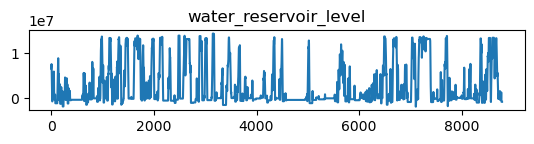

In [9]:
resultado=calculateGas([48, 754])


print(resultado)

figure=plt.figure()
figure.add_subplot(4,1,2).title.set_text('water_reservoir_level')
plt.plot(water_reservoir_level)




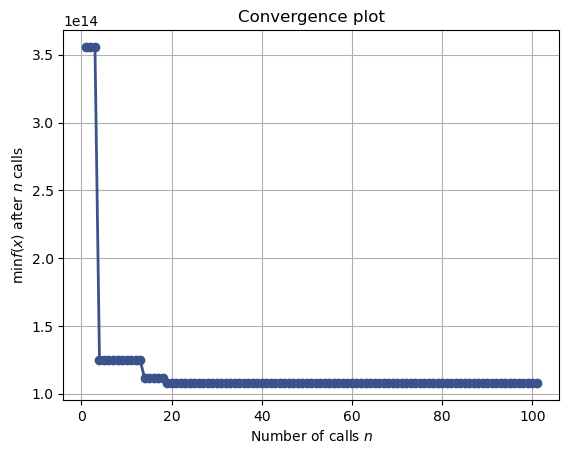

In [10]:
#we have to declare the variables and make the function calc3 
#
#https://scikit-optimize.github.io/stable/auto_examples/bayesian-optimization.html#sphx-glr-auto-examples-bayesian-optimization-py

from skopt import gp_minimize

numero_de_iteraciones=100;

best = gp_minimize(calculateGas, # function to minimize
                   [(0, max_N_nuclearSMR_plants),(0, max_N_wind_turbines)],# bounds on each dimension of x
                   acq_func="EI", # acquisition function
                   n_calls=numero_de_iteraciones+1, # number of evaluations of f
                   n_random_starts=numero_de_iteraciones, # number of random initialization points
                   x0=[1,1], # initial values
                   random_state=1234) # the random seed

from skopt.plots import plot_convergence
plot_convergence(best);

In [11]:
print(best)

          fun: 107858964804572.4
            x: [26.829442984355364, 1701.654474652859]
    func_vals: [355784095935729.06 9999999999999999999999999999999999999
                ... 128384610942714.17 156936236569677.47]
      x_iters: [[1, 1], [28.864492655413663, 3696.629753846895], [35.50248989128171, 3486.5468332580535], [49.91884673990587, 680.8790845395508], [11.514088023517921, 3684.5364619105308], [9.211290484697319, 524.9429808358404], [0.7486368049511065, 2200.48716402987], [19.19889483851729, 3627.930852424603], [5.698612261931438, 253.09038932573696], [25.67443363963493, 100.09048948568321], [16.862256088802138, 1113.7028834915507], [42.820632544852636, 4019.3021152967463], [57.25407953107204, 530.8441214099024], [22.839376433044173, 2046.3387378704224], [31.212574450271937, 3573.611903727795], [27.018507890028673, 1967.7017817531214], [33.0297620840226, 4381.050679279175], [2.352256628412572, 2477.500468069759], [26.829442984355364, 1701.654474652859], [19.01890088351311, 3

In [12]:
print(best.x)

[26.829442984355364, 1701.654474652859]


In [13]:
resultado=calculateGas(best.x) #[26.829442984355364, 1701.654474652859]
resultado

107858964804572.4

In [14]:
resultado=calculateGas([27,1700]) #[26.829442984355364, 1701.654474652859]
resultado

107807950395058.36

In [19]:
def calculate_remaining_money(numbers_of_nuclear_and_wind):

    N_nuclearSMR_plants=np.floor(numbers_of_nuclear_and_wind[0]);
    N_wind_turbines    =np.floor(numbers_of_nuclear_and_wind[1]);
    
    total_nuclearSMR_cost   = N_nuclearSMR_plants *cost_per_nuclear_SMR100Mw;
    total_wind_turbines_cost= N_wind_turbines     *cost_per_wind_turbine_5Mw;
    
    absurdGasNumber=9999999999999999999999999999999999999; #to cheat the optimicing function into not using this N_SMR and N_wind values.
    
    if ((total_nuclearSMR_cost+total_wind_turbines_cost)>total_investment):
        return absurdGasNumber
    else:
        #calculating number of solar panels from remaining money
        total_cost_solar_panels= total_investment-(total_nuclearSMR_cost+total_wind_turbines_cost);
        N_solar_panels         = np.floor(total_cost_solar_panels/cost_per_solar_panel_550w);
        
        return total_investment-(total_nuclearSMR_cost+total_wind_turbines_cost+N_solar_panels*cost_per_solar_panel_550w)

In [20]:
calculate_remaining_money(best.x)

200.0

In [17]:
def calculate_number_of_all(numbers_of_nuclear_and_wind):

    N_nuclearSMR_plants=np.floor(numbers_of_nuclear_and_wind[0]);
    N_wind_turbines    =np.floor(numbers_of_nuclear_and_wind[1]);
    
    total_nuclearSMR_cost   = N_nuclearSMR_plants *cost_per_nuclear_SMR100Mw;
    total_wind_turbines_cost= N_wind_turbines     *cost_per_wind_turbine_5Mw;
    
    absurdGasNumber=9999999999999999999999999999999999999; #to cheat the optimicing function into not using this N_SMR and N_wind values.
    
    if ((total_nuclearSMR_cost+total_wind_turbines_cost)>total_investment):
        return absurdGasNumber
    else:
        #calculating number of solar panels from remaining money
        total_cost_solar_panels= total_investment-(total_nuclearSMR_cost+total_wind_turbines_cost);
        N_solar_panels         = np.floor(total_cost_solar_panels/cost_per_solar_panel_550w);
        
        return [N_nuclearSMR_plants, N_wind_turbines, N_solar_panels]

In [18]:
calculate_number_of_all(best.x)

[26.0, 1701.0, 8875833.0]